Баганууд: ['Газар /Хэлтэс/', 'Зөрчил гарсан газрын хаяг', 'Замын байршил /тайлбар/', 'Зөрчил огноо', 'Уртраг', 'Өргөрөг', 'Газар', 'Авто зам - Замын харьяалал', 'Авто зам - Замын ангилал', 'Авто зам - Замын хучилт Тодорхойгүй', 'Авто зам - Замын хучилт Асфальт', 'Авто зам - Замын хучилт Бетон', 'Авто зам - Замын хучилт Сайжруулсан', 'Авто зам - Замын хучилт Хайрган', 'Авто зам - Замын хучилт Хөрсөн', 'Авто зам - Замын хучилт Цементэн', 'Авто зам - Замын гадаргуу', 'Авто зам - Замын онцлог', 'Авто зам - Зорчих хэсгийн өргөн', 'Авто зам - Зорчих хэсгийн өргөн-2', 'Авто зам - Үзэгдэх орчин', 'Авто зам - Цаг агаар', 'Авто зам - Бусад', 'Авто зам - Замын хэсэг', 'Авто зам - Ослын ноцтой байдал', 'Авто зам - Осолд нөлөөлөх хүчин зүйл', 'Авто зам - Ослын нөхцөл', 'ГБХ: бусад зөрчил', 'анхаарал болгоомжгүй зөрчил', 'архидан согтуурсан зөрчил', 'асран хамгаалагч зөрчил', 'бусад зөрчил', 'бэлдмэл хэрэглэсэн этгээдэд т/х-ийн жолоог шилжүүлсэн зөрчил', 'бүрэн бус тээврийн хэрэгсэл жолоодсон зөрчил

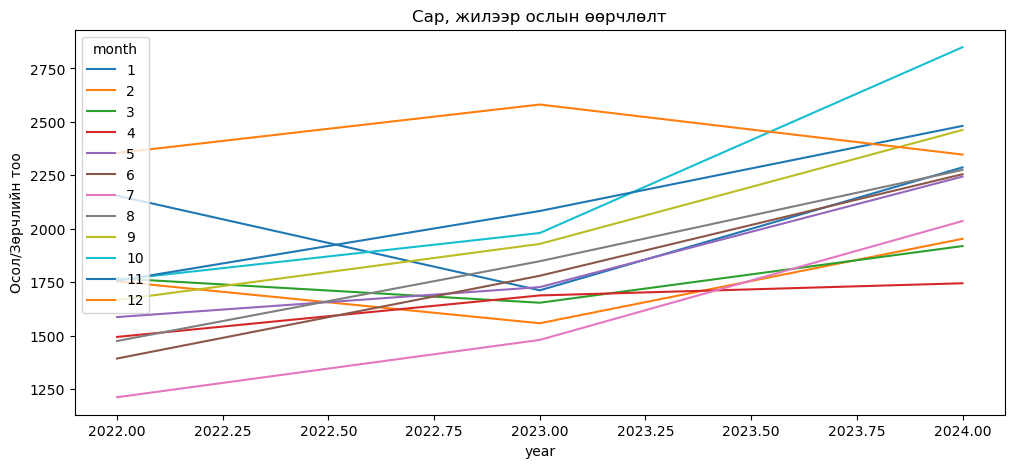

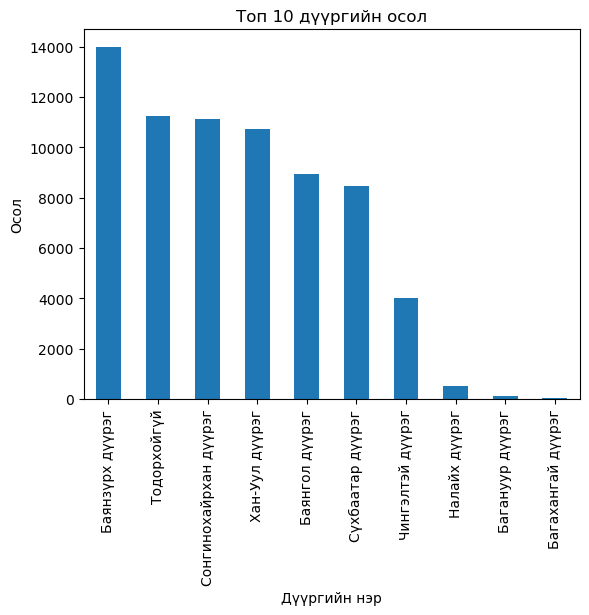

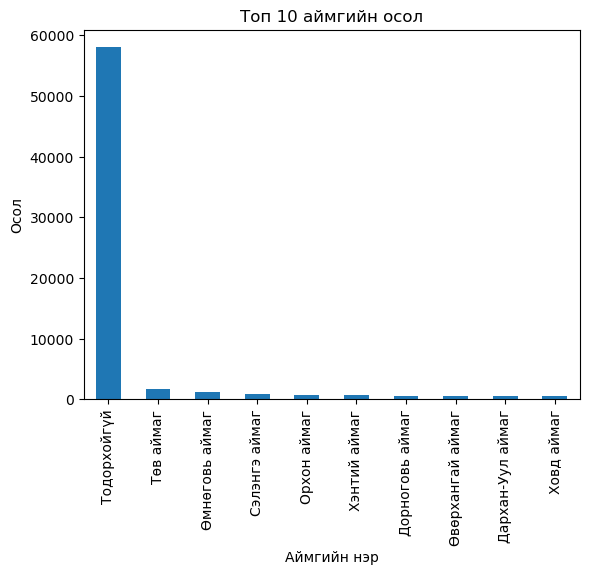

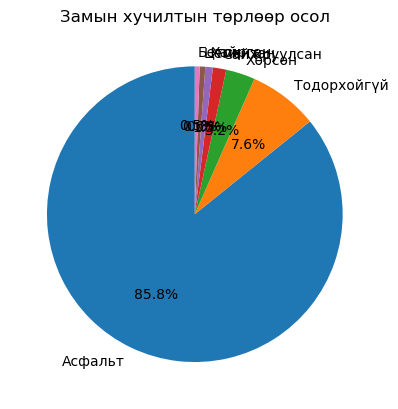

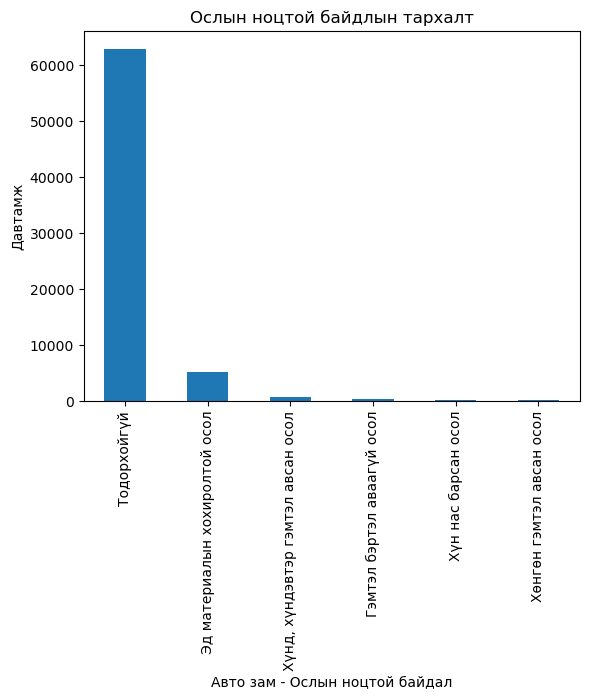

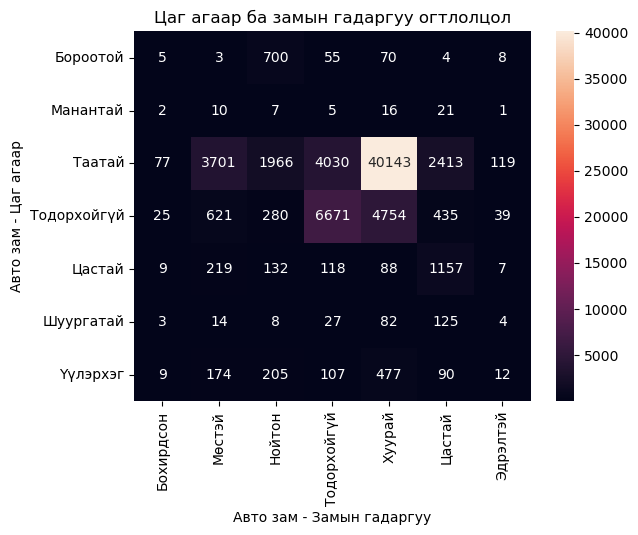

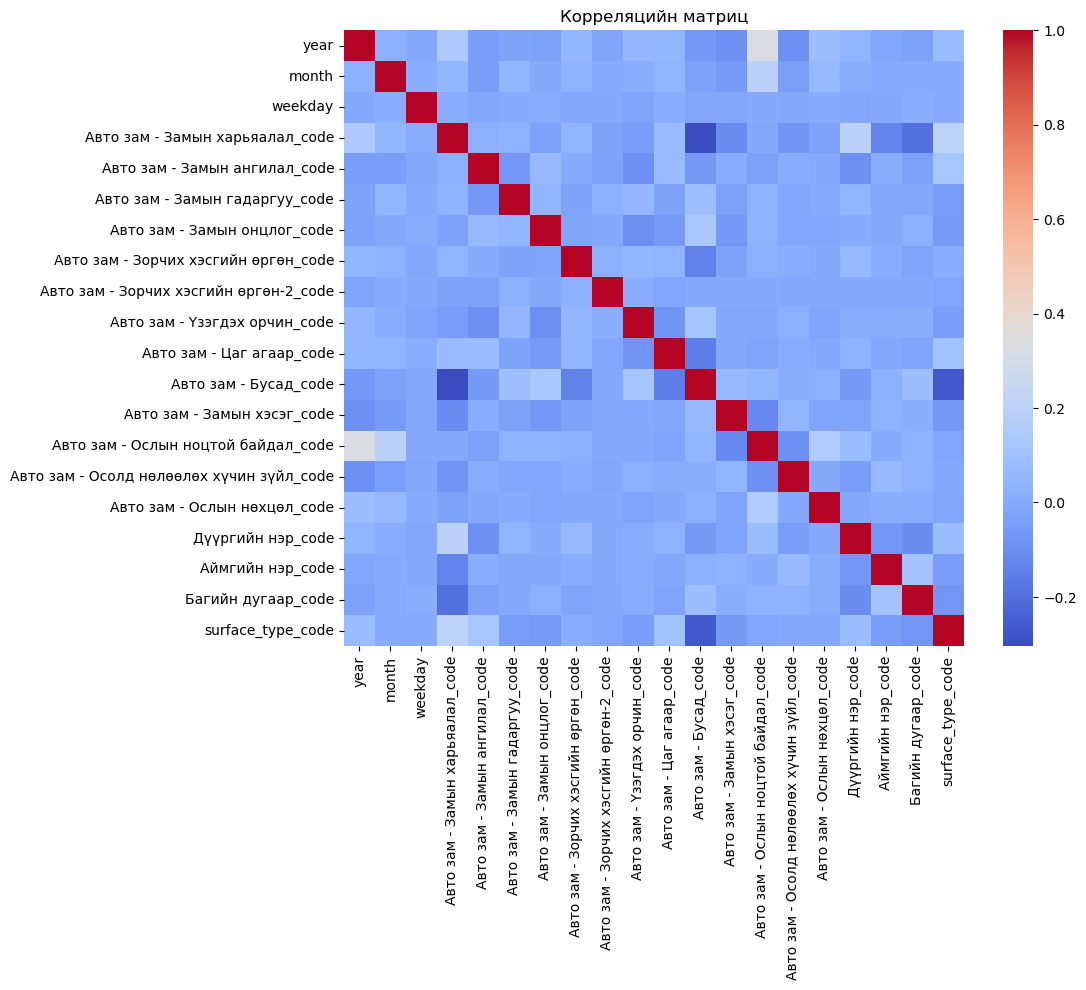

Random Forest
               precision    recall  f1-score   support

           0       0.75      0.16      0.26        57
           1       0.97      0.99      0.98     12579
           2       0.00      0.00      0.00        47
           3       0.42      0.12      0.19       136
           4       0.00      0.00      0.00        21
           5       0.85      0.73      0.79      1010

    accuracy                           0.96     13850
   macro avg       0.50      0.33      0.37     13850
weighted avg       0.95      0.96      0.95     13850

Decision Tree
               precision    recall  f1-score   support

           0       0.29      0.23      0.25        57
           1       0.97      0.97      0.97     12579
           2       0.00      0.00      0.00        47
           3       0.23      0.23      0.23       136
           4       0.00      0.00      0.00        21
           5       0.74      0.75      0.75      1010

    accuracy                           0.94    

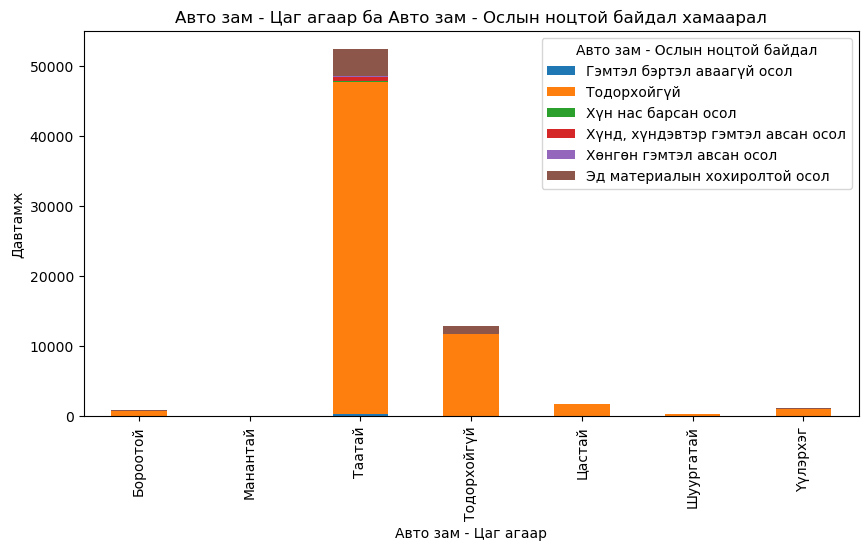

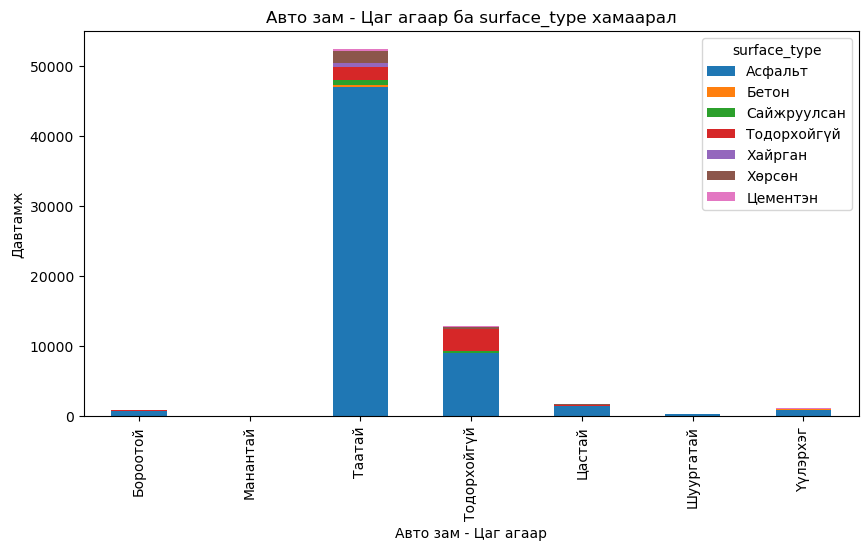

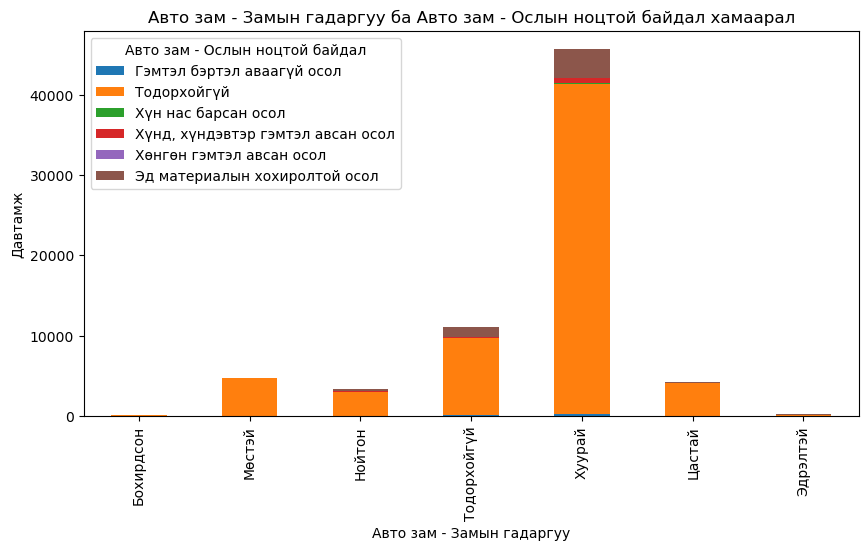

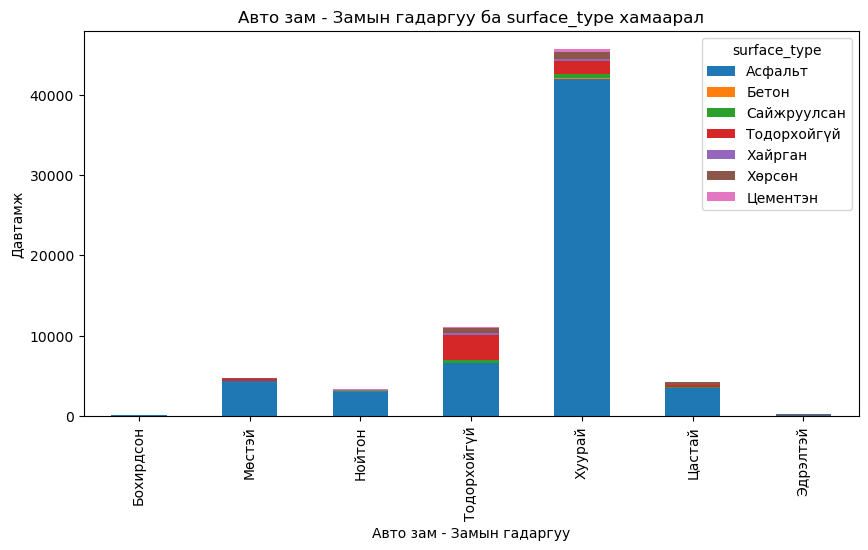

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import folium
from folium.plugins import MarkerCluster
import warnings
warnings.filterwarnings("ignore")


# --- 1. Өгөгдөл унших, үндсэн баганууд автоматаар тодорхойлох ---
file_path = 'ЗТО_2020-2024_ашиглах_final.xlsx'
df = pd.read_excel(file_path)
print("Баганууд:", df.columns.tolist())

# --- 2. Он, сар, цаг, weekday гаргах ---
date_col = [c for c in df.columns if 'огноо' in c.lower()][0]
lat_col = [c for c in df.columns if 'өргөр' in c.lower()][0]
lon_col = [c for c in df.columns if 'уртраг' in c.lower()][0]
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col, lat_col, lon_col])
df['year'] = df[date_col].dt.year
df['month'] = df[date_col].dt.month
df['weekday'] = df[date_col].dt.weekday

# --- 3. Замын хучилт, binary багануудыг нэг баганад нэгтгэх ---
surface_cols = [c for c in df.columns if "хучилт" in c.lower() and ("Асфальт" in c or "Бетон" in c or "Хөрсөн" in c or "Хайрган" in c or "Сайжруулсан" in c or "Тодорхойгүй" in c or "Цементэн" in c)]
def get_surface_type(row):
    for col in surface_cols:
        if row.get(col, 0)==1:
            return col.replace("Авто зам - Замын хучилт ","")
    return "Тодорхойгүй"
df['surface_type'] = df.apply(get_surface_type, axis=1)

# --- 4. Категори хувьсагчдыг кодлох, feature автомат бүрдүүлэх ---
categorical = []
for col in df.columns:
    if df[col].dtype == 'object' and len(df[col].unique()) < 50 and col not in surface_cols:
        df[col] = df[col].fillna('Тодорхойгүй')
        df[col+'_code'] = LabelEncoder().fit_transform(df[col].astype(str))
        categorical.append(col+'_code')

# --- 5. Binary, шалтгаан, зөрчил багануудыг автоматаар олох, нэмэх ---
binary_cols = [col for col in df.columns if df[col].dtype in [int, float] and df[col].nunique() == 2]
violation_cols = [col for col in binary_cols if ('зөрч' in col.lower() or 'согту' in col.lower() or 'хурд' in col.lower()) and col not in surface_cols]

# --- 6. Статистик шинжилгээ ---
## 6.1. Жил, сар, цагийн өөрчлөлт
monthly = df.groupby(['year','month']).size().unstack(fill_value=0)
monthly.plot(figsize=(12,5), title="Сар, жилээр ослын өөрчлөлт")
plt.ylabel("Осол/Зөрчлийн тоо")
plt.show()

## 6.2. Дүүрэг, аймаг, сумын шинжилгээ (top 10)
if 'Дүүргийн нэр' in df.columns:
    df['Дүүргийн нэр'].value_counts().head(10).plot(kind='bar', title="Топ 10 дүүргийн осол")
    plt.ylabel("Осол")
    plt.show()

if 'Аймгийн нэр' in df.columns:
    df['Аймгийн нэр'].value_counts().head(10).plot(kind='bar', title="Топ 10 аймгийн осол")
    plt.ylabel("Осол")
    plt.show()

## 6.3. Замын хучилтаар харьцуулалт (piechart)
df['surface_type'].value_counts().plot.pie(autopct='%.1f%%', startangle=90, title="Замын хучилтын төрлөөр осол")
plt.ylabel('')
plt.show()

## 6.4. Ослын ноцтой байдал
sev_col = [c for c in df.columns if "ноцтой" in c.lower()][0]
df[sev_col].value_counts().plot(kind='bar', title="Ослын ноцтой байдлын тархалт")
plt.ylabel("Давтамж")
plt.show()

## 6.5. Шалтгаан, зөрчлийн шинжилгээ (зөвхөн 0/1 баганууд)
if violation_cols:
    df[violation_cols].sum().sort_values(ascending=False).plot(kind='bar', title="Ослын шалтгааны шинжилгээ")
    plt.ylabel("Осолд оролцсон тоо")
    plt.show()

## 6.6. Цаг агаар, гэрэлтүүлэг, замын гадаргуу
weather_col = [c for c in df.columns if "цаг агаар" in c.lower()][0]
surface_cond_col = [c for c in df.columns if "замын гадаргуу" in c.lower()][0]
crosstab = pd.crosstab(df[weather_col], df[surface_cond_col])
sns.heatmap(crosstab, annot=True, fmt='d')
plt.title("Цаг агаар ба замын гадаргуу огтлолцол")
plt.show()

# --- 7. Орон зайн шинжилгээ (газрын зураг, хар цэг) ---
m = folium.Map(location=[df[lat_col].mean(), df[lon_col].mean()], zoom_start=10)
marker_cluster = MarkerCluster().add_to(m)
for i, row in df.iterrows():
    folium.Marker(
        [row[lat_col], row[lon_col]],
        popup=f"{row.get('Дүүргийн нэр','')}, {row.get('Аймгийн нэр','')}, {row.get('surface_type','')}, {row[date_col]}"
    ).add_to(marker_cluster)
m.save("accident_map.html")

# --- 8. Корреляцийн шинжилгээ ---
features_corr = ['year', 'month', 'weekday'] + categorical + binary_cols
corr = df[features_corr].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Корреляцийн матриц")
plt.show()

# --- 9. Машин сургалтын (RF, DT, LR, GB) таамаглал ---
# Target бол ноцтой байдал (эсвэл өөр ангиллын багана)
target = sev_col+'_code' if sev_col+'_code' in df.columns else sev_col
feature_cols = ['year', 'month', 'weekday', 'surface_type'] + categorical + violation_cols
if target in feature_cols:
    feature_cols.remove(target)
# Surface type code-г нэмэх
if 'surface_type_code' in df.columns:
    feature_cols.append('surface_type_code')
X = df[feature_cols]
y = df[target]
# Категори баганыг дэмжихийн тулд Dummy болгоно
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 9.1 Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
print("Random Forest\n", classification_report(y_test, rf.predict(X_test)))

# --- 9.2 Decision Tree ---
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
print("Decision Tree\n", classification_report(y_test, dt.predict(X_test)))

# --- 9.3 Logistic Regression ---
lr = LogisticRegression(max_iter=400)
lr.fit(X_train, y_train)
print("Logistic Regression\n", classification_report(y_test, lr.predict(X_test)))

# --- 9.4 Gradient Boosting ---
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train, y_train)
print("Gradient Boosting\n", classification_report(y_test, gb.predict(X_test)))

# --- 10. Харьцангуй шинжилгээ: олон хувьсагчийн огтлолцол ---
for c1 in [weather_col, surface_cond_col]:
    for c2 in [sev_col, 'surface_type']:
        if c1 in df.columns and c2 in df.columns:
            cross = pd.crosstab(df[c1], df[c2])
            cross.plot(kind='bar', stacked=True, figsize=(10,5), title=f"{c1} ба {c2} хамаарал")
            plt.ylabel("Давтамж")
            plt.show()
